In [159]:
%autosave 0

from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import matplotlib.pyplot as plt
from math import sin, pi
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

seed = 15
torch.manual_seed(seed)
np.random.seed(seed)

Autosave disabled


# Série temporelle à analyser

## récupération des données

In [10]:
data = pd.read_csv("interstate_traffic.csv")
data.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


## Conversion au format date

In [11]:
print(type(data['date_time'][0]))
data['date_time'] = pd.to_datetime(data['date_time'])
print(type(data['date_time'][0]))

<class 'str'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


## Colonne date mise en index du dataframe

In [12]:
data.set_index('date_time', inplace=True)
data.index

DatetimeIndex(['2012-10-02 09:00:00', '2012-10-02 10:00:00',
               '2012-10-02 11:00:00', '2012-10-02 12:00:00',
               '2012-10-02 13:00:00', '2012-10-02 14:00:00',
               '2012-10-02 15:00:00', '2012-10-02 16:00:00',
               '2012-10-02 17:00:00', '2012-10-02 18:00:00',
               ...
               '2018-09-30 15:00:00', '2018-09-30 15:00:00',
               '2018-09-30 16:00:00', '2018-09-30 17:00:00',
               '2018-09-30 18:00:00', '2018-09-30 19:00:00',
               '2018-09-30 20:00:00', '2018-09-30 21:00:00',
               '2018-09-30 22:00:00', '2018-09-30 23:00:00'],
              dtype='datetime64[ns]', name='date_time', length=48204, freq=None)

## visualisation des données

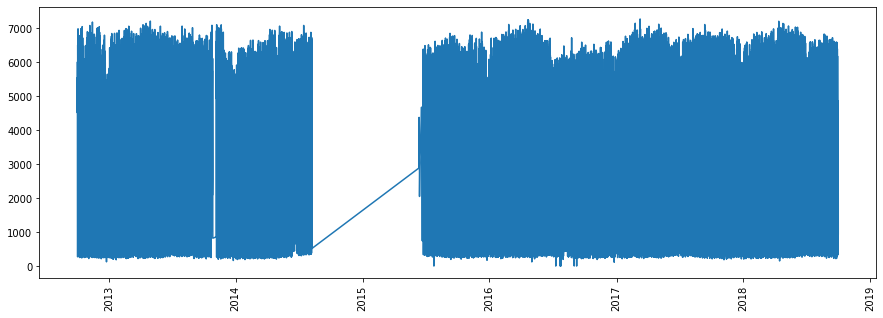

In [13]:
plt.figure(figsize=(15,5))
plt.plot(data['traffic_volume']);
plt.xticks(rotation=90);

## Vérification des intervales temporels

In [14]:
time_delta = pd.DataFrame(data.index).diff()
time_delta.head()

,date_time
0,NaT
1,01:00:00
2,01:00:00
3,01:00:00
4,01:00:00


In [15]:
time_delta = time_delta[1:]

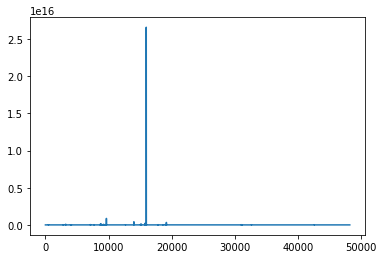

In [16]:
plt.plot(time_delta.values);

## traitement d'un sous-dataset sans périodes creuses trop longues

In [17]:
data = data[data.index.year >= 2016]

In [18]:
data = pd.DataFrame(data['traffic_volume'])

In [19]:
data.shape

(27860, 1)

In [20]:
data.head()

,traffic_volume
date_time,
2016-01-01 00:00:00,1513
2016-01-01 00:00:00,1513
2016-01-01 01:00:00,1550
2016-01-01 03:00:00,719
2016-01-01 04:00:00,533


## suppression des doublons

In [21]:
deleted_lines = 0
datata_lines = data.shape[0]
for i in range(datata_lines-1, 0, -1):
    if data.index[i] == data.index[i-1]:
        data = data.drop(data.index[i])
        deleted_lines += 1
        
print("nombre de lignes doublons supprimées : ", deleted_lines)

nombre de lignes doublons supprimées :  3469


In [22]:
data.shape

(19615, 1)

In [23]:
data.describe()

,traffic_volume
count,19615.000000
mean,3335.791690
std,1963.492407
min,0.000000
25%,1334.500000
50%,3540.000000
75%,4947.000000
max,7280.000000


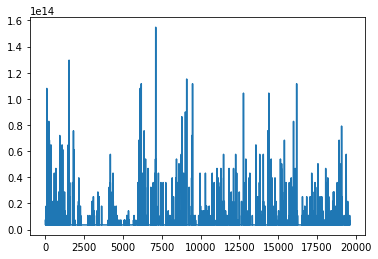

In [24]:
time_delta = pd.DataFrame(data.index)
time_delta = time_delta.diff()
time_delta = time_delta[1:]
plt.plot(time_delta.values);

## Changement de l'intervalle de temps minimum : 1h -> données journalières

In [25]:
data = data.resample('d').mean()

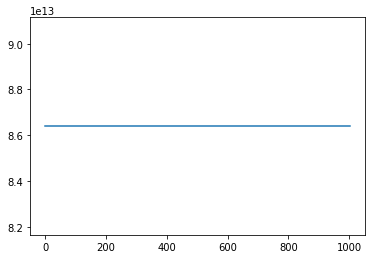

In [26]:
time_delta = pd.DataFrame(data.index)
time_delta = time_delta.diff()
time_delta = time_delta[1:]
plt.plot(time_delta.values);

In [27]:
data[data['traffic_volume'].isna()]

,traffic_volume
date_time,
2016-11-30,NaN
2017-01-21,NaN
2017-05-01,NaN


## Nouvelle réduction de la taille du dataset pour avoir des données continues

In [30]:
data = data[data.index.year >= 2018]

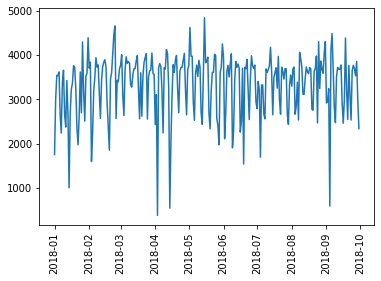

In [31]:
plt.plot(data['traffic_volume']);
plt.xticks(rotation=90);

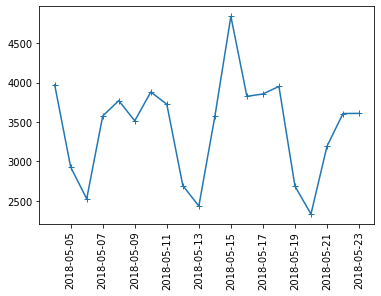

In [32]:
plt.plot(data['traffic_volume'][-150:-130], '-+');
plt.xticks(rotation=90);

# Analyse des données

## Analyse en fréquence pour déterminer la période des oscillations

In [33]:
magnitude = np.fft.rfft(data['traffic_volume'])
freq = np.fft.rfftfreq(data.shape[0])

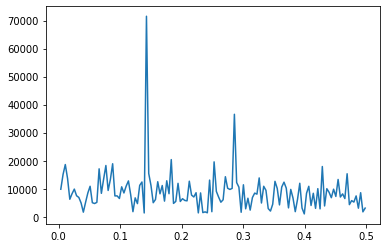

In [34]:
plt.figure()
plt.plot(freq[1:], np.absolute(magnitude[1:]));

In [35]:
1/freq[magnitude == max(magnitude[1:])]

array([3.5])

## Décomposition temporelle

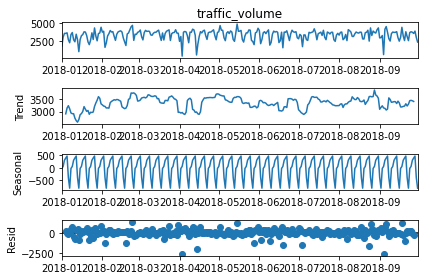

In [38]:
result = seasonal_decompose(data['traffic_volume'], model='additive',
                           period=7)
result.plot();

## séparation en données d'entraînement et de validation

(245, 1)
(245,)
(28, 1)
(28,)


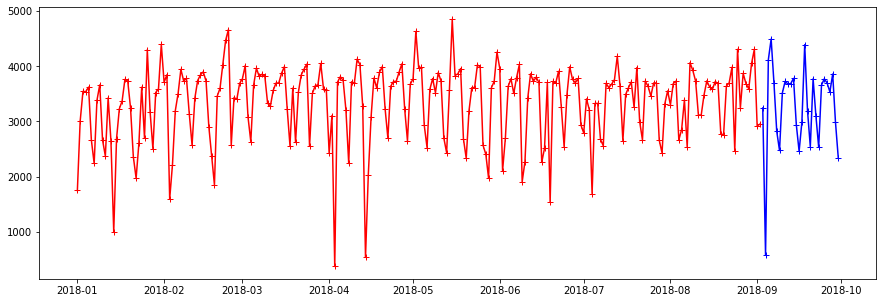

In [141]:
split = 0.9
val = data['traffic_volume'][int(len(data)*split):].values.reshape(-1,1)
time_steps_val = data.index[int(len(data)*split):]

train = data['traffic_volume'][:int(len(data)*split)].values.reshape(-1,1)
time_steps_train = data.index[:int(len(data)*split)]

print(train.shape)
print(time_steps_train.shape)
print(val.shape)
print(time_steps_val.shape)

plt.figure(figsize=(15,5))
plt.plot(time_steps_train, train, '-+r')
plt.plot(time_steps_val, val, '-+b');

## normalisation

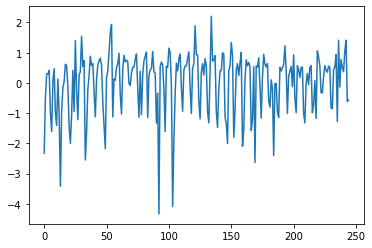

In [223]:
scaler = StandardScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)
val_scaled = scaler.transform(val)
plt.plot(train_scaled);

# Sinus reference that works

In [172]:
time_steps2 = np.linspace(0,999,300)
A, omega, fi = 100, 0.03, 3
sinus = A*np.sin(omega*time_steps2+fi)
sinus.resize((len(sinus), 1)) # input_size=1

val2 = sinus[int(len(sinus)*.8):]
time_steps_val2 = time_steps2[int(len(sinus)*.8):]

train2 = sinus[:int(len(sinus)*.8)]
time_steps_train2 = time_steps2[:int(len(sinus)*.8)]

print(train2.shape)
print(time_steps_train2.shape)
print(val2.shape)
print(time_steps_val2.shape)

(240, 1)
(240,)
(60, 1)
(60,)


# modèle RNN

## création du modèle

In [173]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim=hidden_dim
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        batch_size = x.size(0)

        r_out, hidden = self.rnn(x, hidden)
        r_out = r_out.view(-1, self.hidden_dim)  
        output = self.fc(r_out)
        
        return output, hidden

## fonction pour entraîner le modèle

In [285]:
# train the RNN
def train_evaluate_model(rnn, epochs, time_steps_train, train, time_steps_val, val):
    
    x_train = train[:-1]
    y_train = train[1:]
    x_val = val[:-1]
    y_val = val[1:]
    
    # convert data into Tensors
    x_train_tensor = torch.Tensor(x_train).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
    y_train_tensor = torch.Tensor(y_train)
    # convert data into Tensors
    x_val_tensor = torch.Tensor(x_val).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
    y_val_tensor = torch.Tensor(y_val)
        
    train_losses = []
    val_losses = []

    # initialize the hidden state
    train_hidden = None
    val_hidden = None
    
    for epoch in range(epochs):       
        
        # outputs from the rnn
        train_prediction, train_hidden = rnn(x_train_tensor, train_hidden)
        val_prediction, val_hidden = rnn(x_val_tensor, val_hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        train_hidden = train_hidden.data
        val_hidden = val_hidden.data

        # calculate the loss
        train_loss = criterion(train_prediction, y_train_tensor)
        train_losses += [train_loss]
        val_loss = criterion(val_prediction, y_val_tensor)
        val_losses += [val_loss]
        
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        train_loss.backward()
        optimizer.step()

        # display loss and predictions
        if (epoch+1)%int(epochs/4) == 0:        
            print('Train Loss: ', train_loss.item())
            print('Val Loss: ', val_loss.item())
            plt.figure(figsize=(15,5))
            plt.plot(time_steps_train[:-1], x_train, color='C0')
            plt.plot(time_steps_train[1:], train_prediction.data.numpy().flatten(), color='C1')
            plt.legend(['train', 'train predict'])
            plt.show()
            
    plt.figure(figsize=(15,5))
    plt.plot(time_steps_val[:-1], x_val, color='C3')
    plt.plot(time_steps_val[1:], val_prediction.data.numpy().flatten(), color='C4')
    plt.legend(['val', 'val predict'])
    
    plt.figure(figsize=(15,5))
    plt.plot(train_losses, 'b-')
    plt.plot(val_losses, 'r-')
    plt.legend(['train loss', 'val loss'])
    
    return rnn

## définition des hyperparamètres

In [354]:
# decide on hyperparameters
input_size = 1 
output_size = 1 # un seul point à prédire à la fois
hidden_dim = 10 # on décide d'utiliser 10 neurones par couche
n_layers = 2 # modèle à une couche seulement

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

test_input = torch.Tensor(train).unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

RNN(
  (rnn): RNN(1, 10, num_layers=2, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)
Input size:  torch.Size([1, 245, 1])
Output size:  torch.Size([245, 1])
Hidden state size:  torch.Size([2, 1, 10])


## entraînement du modèle et visualisation

Train Loss:  0.8235833048820496
Val Loss:  1.2781291007995605


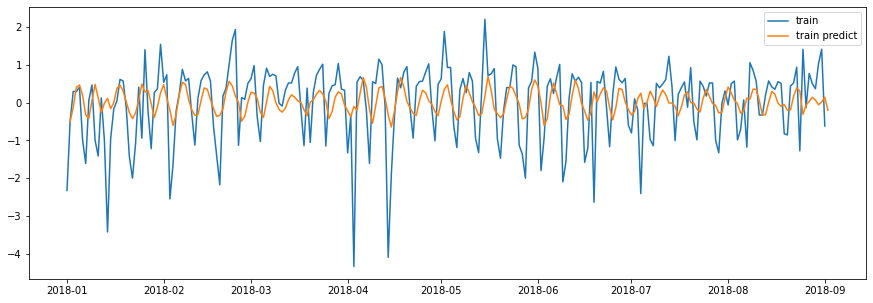

Train Loss:  0.7102017402648926
Val Loss:  1.1950258016586304


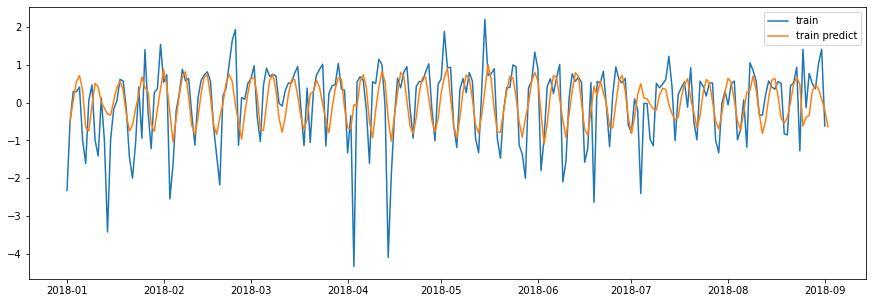

Train Loss:  0.635041356086731
Val Loss:  1.2084975242614746


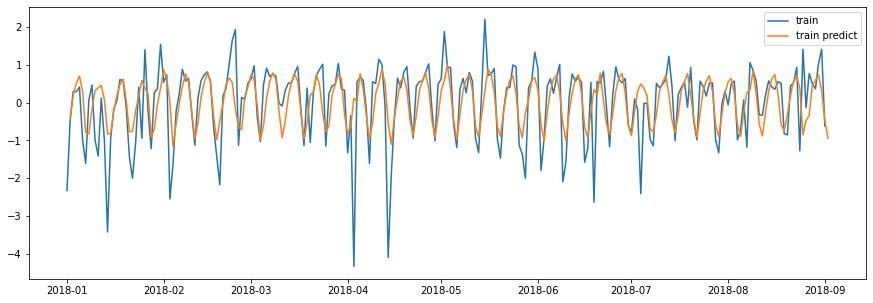

Train Loss:  0.6202162504196167
Val Loss:  1.245752215385437


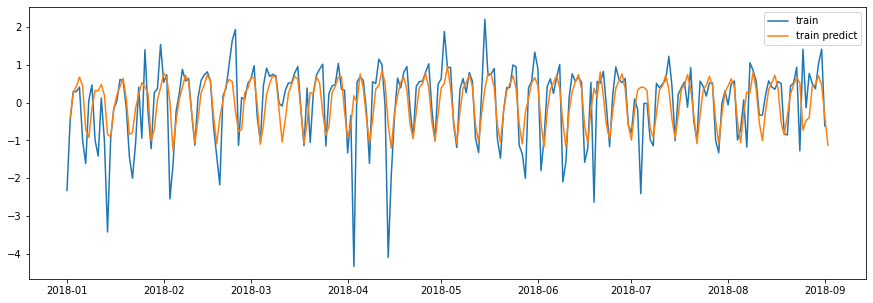

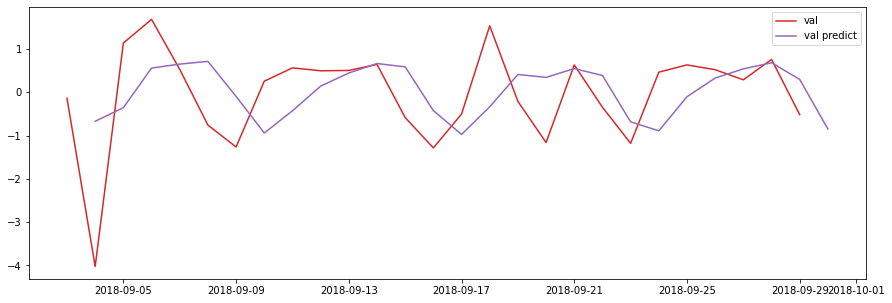

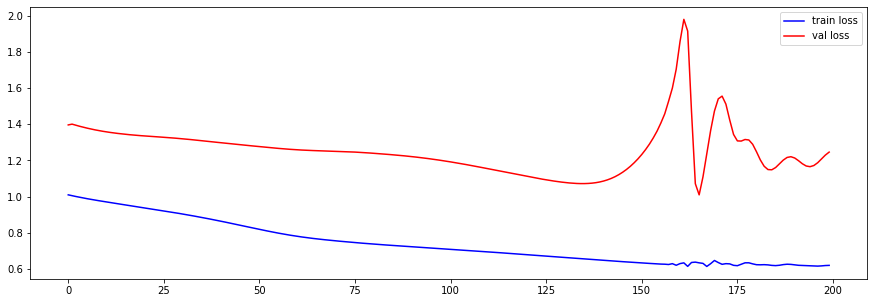

In [355]:
# train the rnn and monitor results
epochs = 200 # nombre d'epoch à réaliser

learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

trained_rnn = train_evaluate_model(rnn, epochs, time_steps_train, train_scaled, time_steps_val, val_scaled)

# modèle LSTM

## création du modèle

In [318]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers):
        super().__init__()
        
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

## définition des hyperparamètres

In [328]:
input_size=1
hidden_layer_size=10
output_size=1
num_layers=1

model = LSTM(input_size, hidden_layer_size, output_size, num_layers)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)

LSTM(
  (lstm): LSTM(1, 10)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)


## découpage du train avec fenêtre glissante

In [329]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [330]:
train_data_normalized = torch.FloatTensor(train_scaled).view(-1)

In [331]:
train_window = 10
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

## entraînement du modèle et visualisation

epoch:   9 loss: 0.00018630


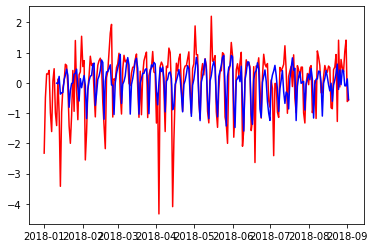

epoch:  19 loss: 0.02040436


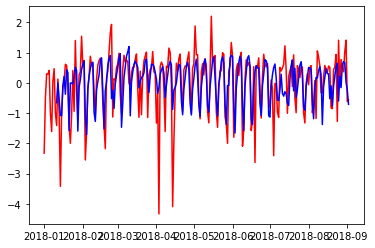

epoch:  29 loss: 0.01432952


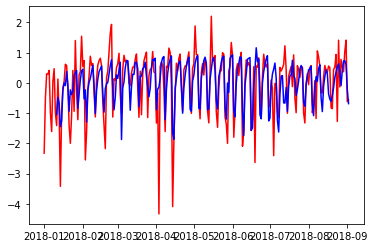

epoch:  39 loss: 0.12324539


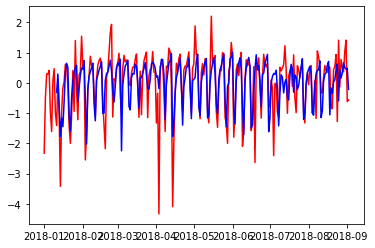

In [332]:
epochs = 40

for i in range(epochs):
    y_all = []
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        
        y_all += [y_pred.data.numpy().flatten()[0]]

    if (i+1)%int(epochs/4) == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
        plt.figure(figsize=(15,5))
        plt.plot(time_steps_train, train_scaled, 'r-') # input
        plt.plot(time_steps_train[train_window:], y_all, 'b-') # predictions
        plt.show()

## évaluation du modèle

In [333]:
val_data_normalized = torch.FloatTensor(val_scaled).view(-1)

In [334]:
val_inout_seq = create_inout_sequences(val_data_normalized, train_window)

loss: 0.31030995


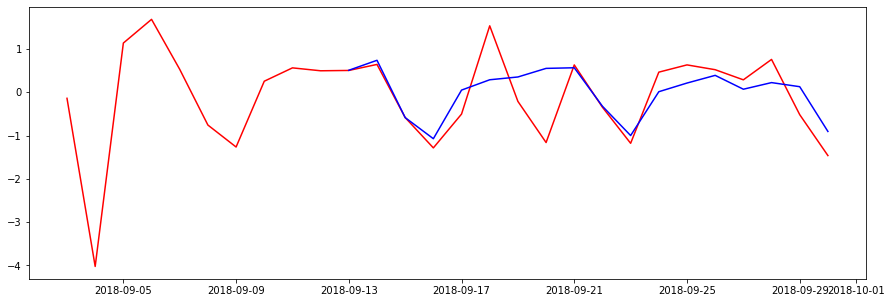

In [336]:
y_all = []
for seq, labels in val_inout_seq:
    y_pred = model(seq)

    single_loss = loss_function(y_pred, labels)

    y_all += [y_pred.data.numpy().flatten()[0]]

print(f'loss: {single_loss.item():10.8f}')
plt.figure(figsize=(15,5))
plt.plot(time_steps_val, val_scaled, 'r-') # input
plt.plot(time_steps_val[train_window:], y_all, 'b-') # predictions
plt.show()

# modèle GRU

## définition des hyperparamètres

In [341]:
input_size=1
hidden_layer_size=10
output_size=1
num_layers=1
learning_rate = 0.002

## création du modèle

model = torch.nn.Sequential(
    torch.nn.GRU(input_size, hidden_layer_size),
    torch.nn.Linear(hidden_layer_size, output_size),
)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(model)

In [342]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers):
        super().__init__()
        
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.GRU(input_size, hidden_layer_size, num_layers)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = torch.zeros(1,1,self.hidden_layer_size)

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

model = GRU(input_size, hidden_layer_size, output_size, num_layers)

## entraînement du modèle et visualisation

In [343]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epoch:   9 loss: 0.02484008


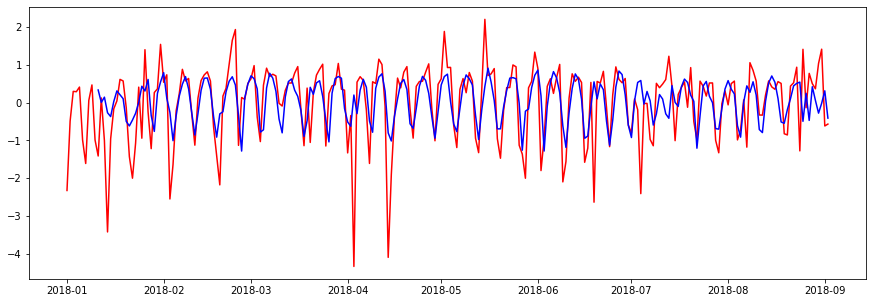

epoch:  19 loss: 0.05511849


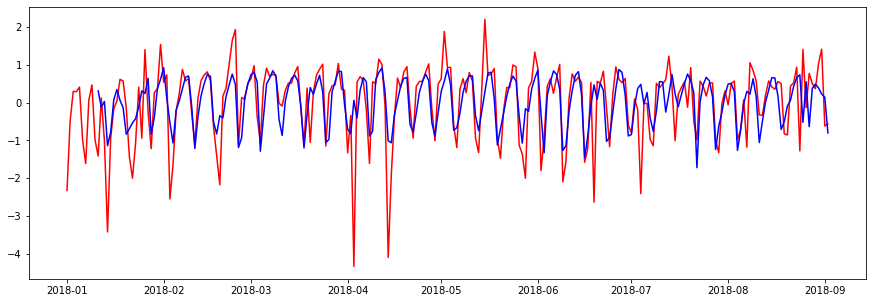

epoch:  29 loss: 0.09438159


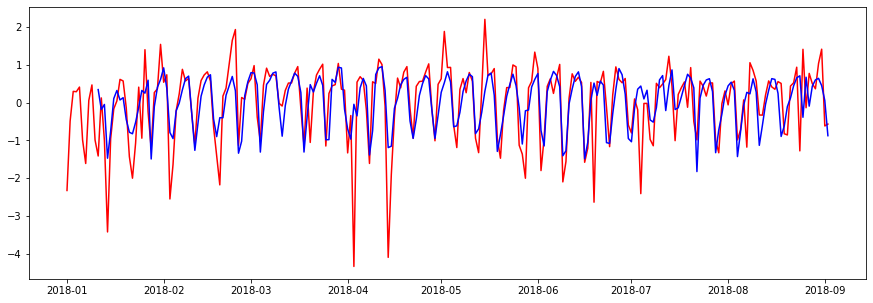

epoch:  39 loss: 0.00309896


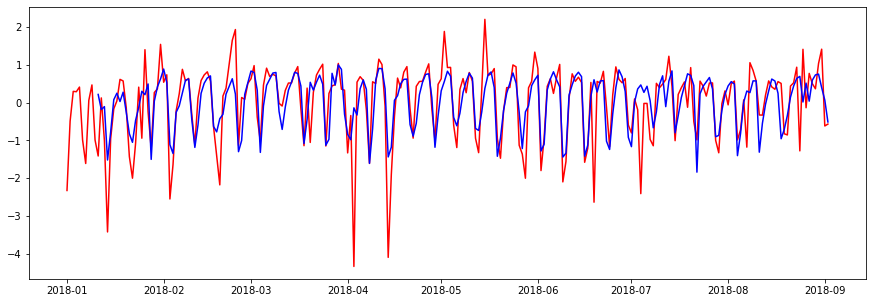

In [344]:
epochs = 40

for i in range(epochs):
    y_all = []
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        
        model.hidden_cell = torch.zeros(1, 1, hidden_layer_size)
        
        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        
        y_all += [y_pred.data.numpy().flatten()[0]]

    if (i+1)%int(epochs/4) == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
        plt.figure(figsize=(15,5))
        plt.plot(time_steps_train, train_scaled, 'r-') # input
        plt.plot(time_steps_train[train_window:], y_all, 'b-') # predictions
        plt.show()

## évaluation du modèle

In [349]:
val_data_normalized = torch.FloatTensor(val_scaled).view(-1)

In [350]:
val_inout_seq = create_inout_sequences(val_data_normalized, train_window)

loss: 0.19608201


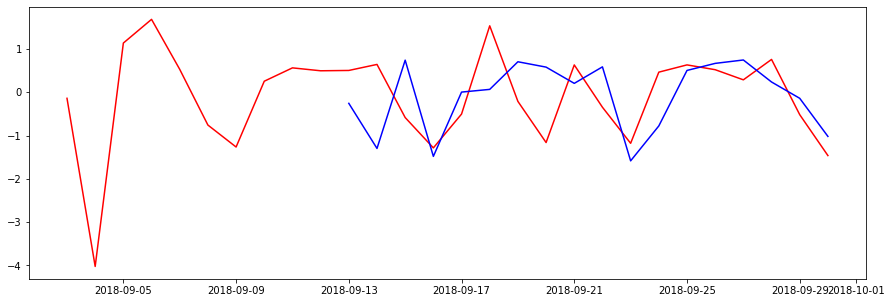

In [351]:
y_all = []
for seq, labels in val_inout_seq:
    y_pred = model(seq)

    single_loss = loss_function(y_pred, labels)

    y_all += [y_pred.data.numpy().flatten()[0]]

print(f'loss: {single_loss.item():10.8f}')
plt.figure(figsize=(15,5))
plt.plot(time_steps_val, val_scaled, 'r-') # input
plt.plot(time_steps_val[train_window:], y_all, 'b-') # predictions
plt.show()